# Final Project
### EN.601.666 Information Retrieval and Web Agents
### Isabel Dinan idinan1@jh.edu

In [13]:
# !pip install "scipy<1.13"
# !pip install pyspellchecker

In [1]:
import requests
import os
import json
from io import BytesIO
import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk import bigrams, trigrams
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
import string
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import time
import xml.etree.ElementTree as ET
from collections import defaultdict, Counter

In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [3]:
def fetch_papers(search_query, max_results=10, start_index=0):
    """Fetch papers related to machine learning using the arXiv API, parsing XML response."""
    query_params = {
        'search_query': search_query,
        'start': start_index,
        'max_results': max_results
    }
    try:
        response = requests.get('http://export.arxiv.org/api/query', params=query_params)
        response.raise_for_status()
        return parse_xml_response(response.text)
    except requests.exceptions.RequestException as e:
        print(f"Error fetching papers: {e}")
        return []

In [4]:
def parse_xml_response(xml_data):
    """Parse the XML and extract IDs, titles, PDF links, and publication dates."""
    namespaces = {'atom': 'http://www.w3.org/2005/Atom'}
    root = ET.fromstring(xml_data)
    entries = []
    for entry in root.findall('atom:entry', namespaces):
        id = entry.find('atom:id', namespaces).text
        title = entry.find('atom:title', namespaces).text
        pdf_link = entry.find("atom:link[@title='pdf']", namespaces).attrib['href']
        published = entry.find('atom:published', namespaces).text[:4]  # Extract year part
        entries.append({'id': id, 'title': title, 'pdf_link': pdf_link, 'year': published})
    return entries

In [5]:
def download_pdfs(entries, download_dir, recorded_ids):
    """Download PDFs for each entry and return paths, checking against existing downloads."""
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)
    pdf_paths = []
    for entry in entries:
        entry_id = entry['id'].split('/')[-1]
        file_name = f"{entry_id}.pdf"
        file_path = os.path.join(download_dir, file_name)
        
        if entry_id not in recorded_ids:
            try:
                response = requests.get(entry['pdf_link'])
                response.raise_for_status()
                with open(file_path, 'wb') as f:
                    f.write(response.content)
                print(f"Downloaded {file_name}")
            except requests.RequestException as e:
                print(f"Error downloading PDF {entry['pdf_link']}: {e}")
                continue
        else:
            if not os.path.exists(file_path):
                try:
                    response = requests.get(entry['pdf_link'])
                    response.raise_for_status()
                    with open(file_path, 'wb') as f:
                        f.write(response.content)
                    print(f"Downloaded file {file_name}")
                except requests.RequestException as e:
                    print(f"Error redownloading PDF {entry['pdf_link']}: {e}")
                    continue
        if os.path.exists(file_path):
            pdf_paths.append(file_path)
        time.sleep(3)
    return pdf_paths

In [6]:
def extract_text_from_pdf(pdf_path):
    """Extract text from a single PDF file."""
    try:
        text = ''
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text
        return text
    except Exception as e:
        print(f"Error processing PDF {pdf_path}: {e}")
        return ""

In [45]:
def preprocess_text(text, n=1):
    """Preprocess text data by tokenizing, removing stopwords, lemmatizing, and checking spelling."""
    spell = SpellChecker()
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha() and word not in string.punctuation and len(word) > 1]
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    filtered_tokens = []
    
    for word in tokens:
        if word not in stop_words:
            if word in spell:
                filtered_tokens.append(lemmatizer.lemmatize(word))
    
    if n == 1:
        return filtered_tokens
    elif n == 2:
        return filtered_tokens + [' '.join(gram) for gram in bigrams(filtered_tokens)]
    elif n == 3:
        return filtered_tokens + [' '.join(gram) for gram in bigrams(filtered_tokens)] + [' '.join(gram) for gram in trigrams(filtered_tokens)]
    else:
        raise ValueError("Unsupported n-gram length: Use 1, 2, or 3")

In [46]:
def record_downloads(entries, download_dir, csv_path):
    """Record details of downloaded files in a CSV file and update only new entries."""
    if not os.path.exists(csv_path):
        df = pd.DataFrame(columns=['id', 'title', 'pdf_path', 'year'])
    else:
        df = pd.read_csv(csv_path)

    new_records = []
    for entry in entries:
        record = {
            'id': entry['id'].split('/')[-1],
            'title': entry['title'],
            'pdf_path': os.path.join(download_dir, f"{entry['id'].split('/')[-1]}.pdf"),
            'year': entry['year']
        }
        if not df['id'].str.contains(record['id']).any():
            new_records.append(record)

    if new_records:
        df = pd.concat([df, pd.DataFrame(new_records)], ignore_index=True)
        df.to_csv(csv_path, index=False)

    return set(df['id'])

In [47]:
def calculate_start_index(csv_path):
    """Determine index of the first document"""
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        return len(df)
    return 0

In [55]:
def calculate_normalized_frequencies(df):
    """Calculate frequencies of n-grams by year, normalized by the number of documents that year"""
    term_frequencies_by_year = {}
    document_count_by_year = {}

    for index, row in df.iterrows():
        year = row['year']
        pdf_path = row['pdf_path']
        if os.path.exists(pdf_path):
            text = extract_text_from_pdf(pdf_path)
            ngrams = preprocess_text(text, n=2)
            if year in term_frequencies_by_year:
                term_frequencies_by_year[year].update(ngrams)
                document_count_by_year[year] += 1
            else:
                term_frequencies_by_year[year] = Counter(ngrams)
                document_count_by_year[year] = 1
        else:
            print(f"File not found: {pdf_path}")
    
    normalized_frequencies_by_year = {}
    for year, frequencies in term_frequencies_by_year.items():
        normalized_frequencies = {term: (count / document_count_by_year[year]) for term, count in frequencies.items()}
        normalized_frequencies_by_year[year] = normalized_frequencies

    return normalized_frequencies_by_year

In [56]:
def get_top_terms_per_year(normalized_frequencies_by_year, top_n=20):
    """Get most common n terms per year"""
    top_terms_by_year = {}
    for year, frequencies in normalized_frequencies_by_year.items():
        sorted_terms = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)[:top_n]
        top_terms_by_year[year] = sorted_terms
    return top_terms_by_year

In [57]:
def plot_top_terms(top_terms_by_year):
    """Bar chart of top 20 n-grams per year"""
    for year, terms in top_terms_by_year.items():
        terms, frequencies = zip(*terms)
        plt.figure(figsize=(10, 8))
        plt.barh(terms, frequencies, color='skyblue')
        plt.xlabel('Normalized Frequency')
        plt.title(f'Top 20 Most Frequent Terms in {year}')
        plt.gca().invert_yaxis()
        plt.show()

In [58]:
API_BASE_URL = 'http://export.arxiv.org/api/query'
download_dir = os.path.join(os.getcwd(), 'downloaded_pdfs')
csv_path = os.path.join(os.getcwd(), 'download_log.csv')

In [59]:
max_results = 0
start_index = calculate_start_index(csv_path)
papers = fetch_papers(search_query = 'cat:cs.LG OR cat:stat.ML', max_results = max_results, start_index = start_index)

In [60]:
recorded_ids = record_downloads(papers, download_dir, csv_path)
pdf_paths = download_pdfs(papers, download_dir, recorded_ids)

In [ ]:
csv_path = 'download_log.csv'
df = pd.read_csv(csv_path)
normalized_frequencies_by_year = calculate_normalized_frequencies(df)

dict_keys([2007, 2008, 2009, 2010, 2011, 2012, 2013])


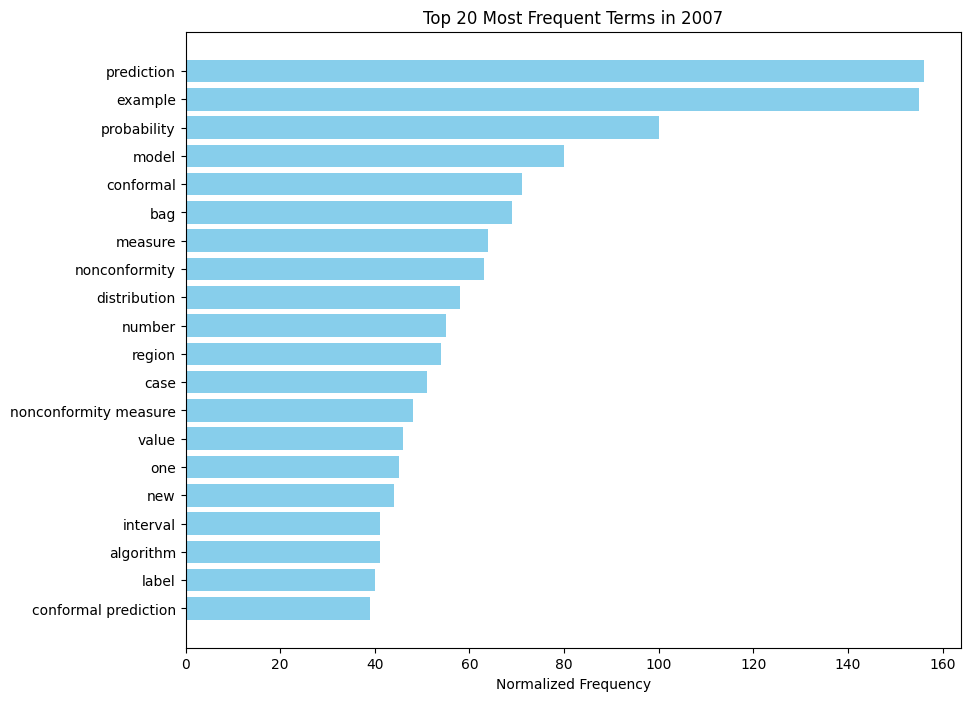

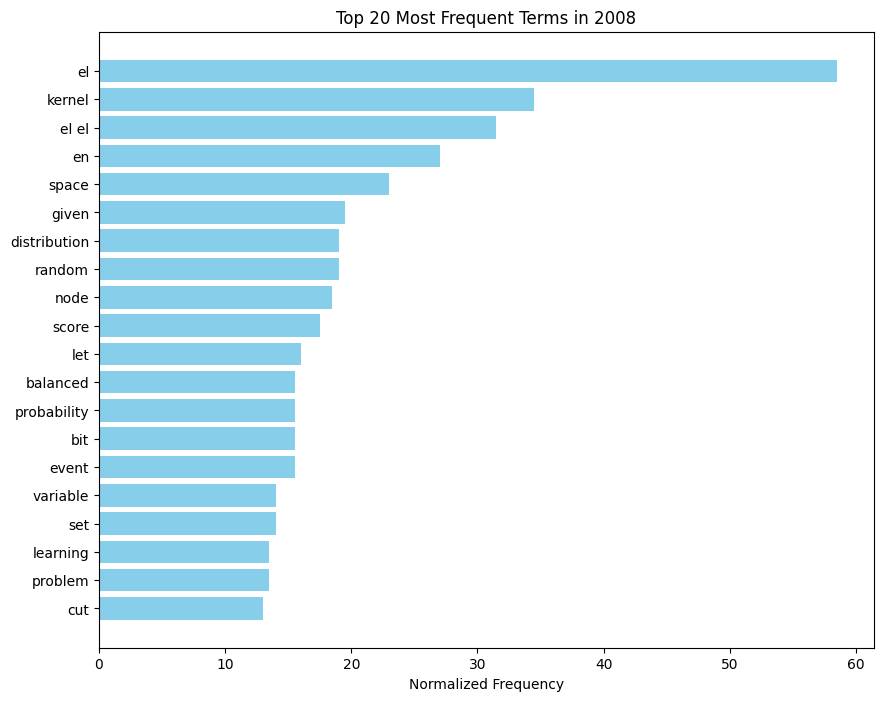

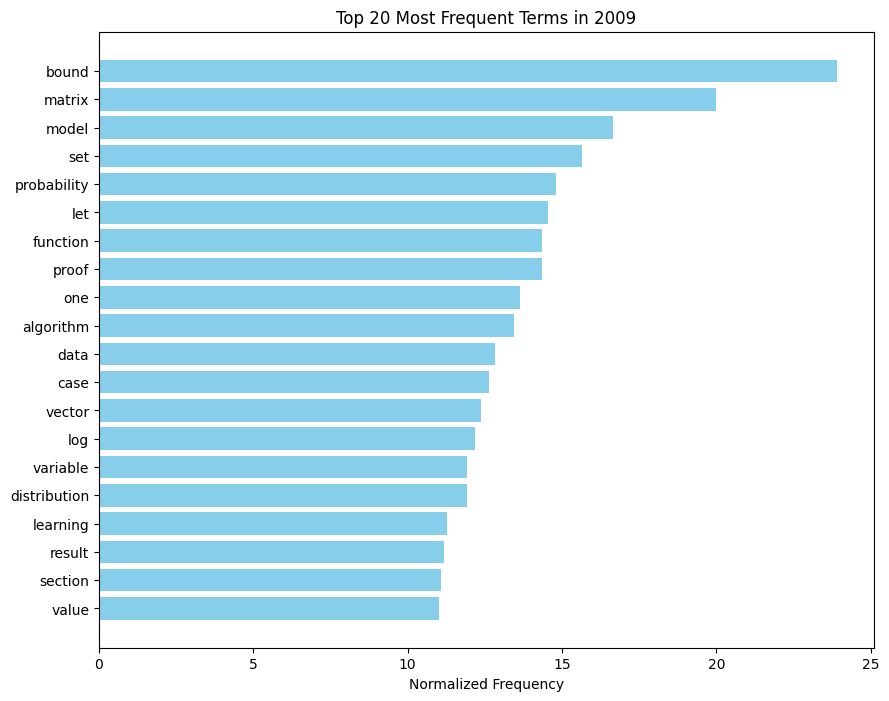

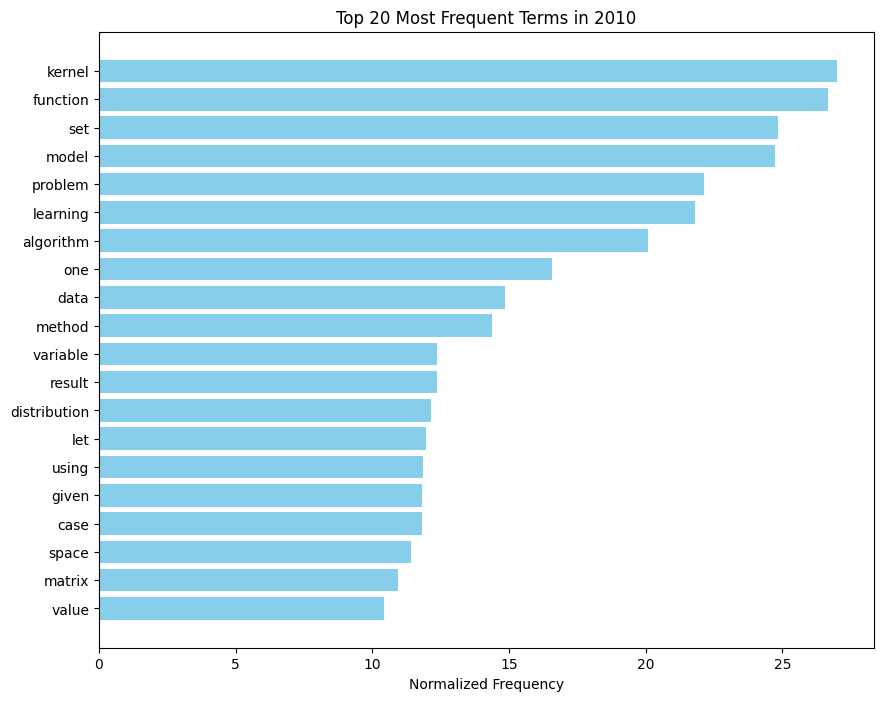

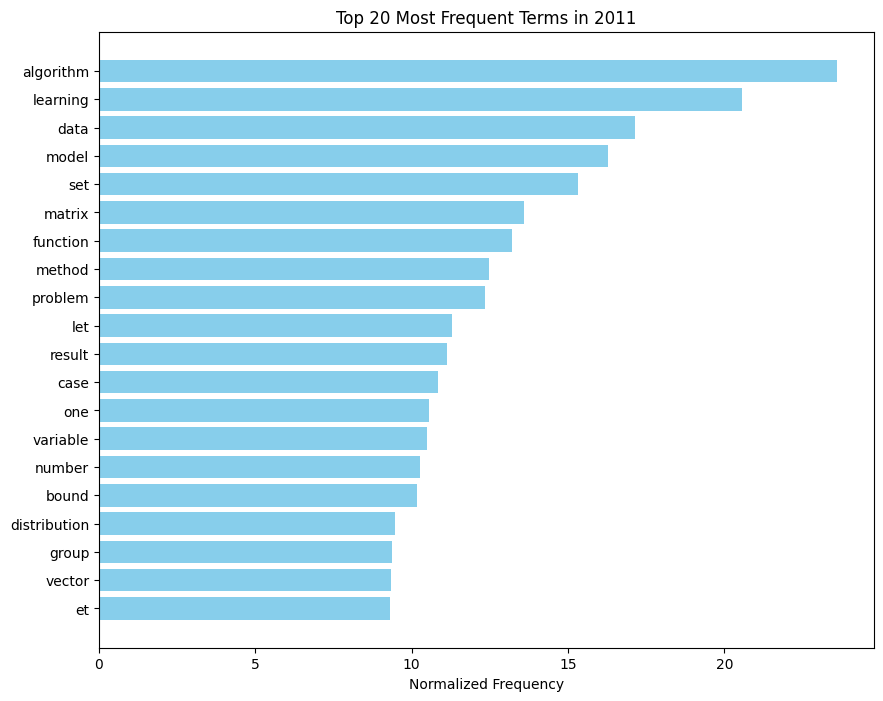

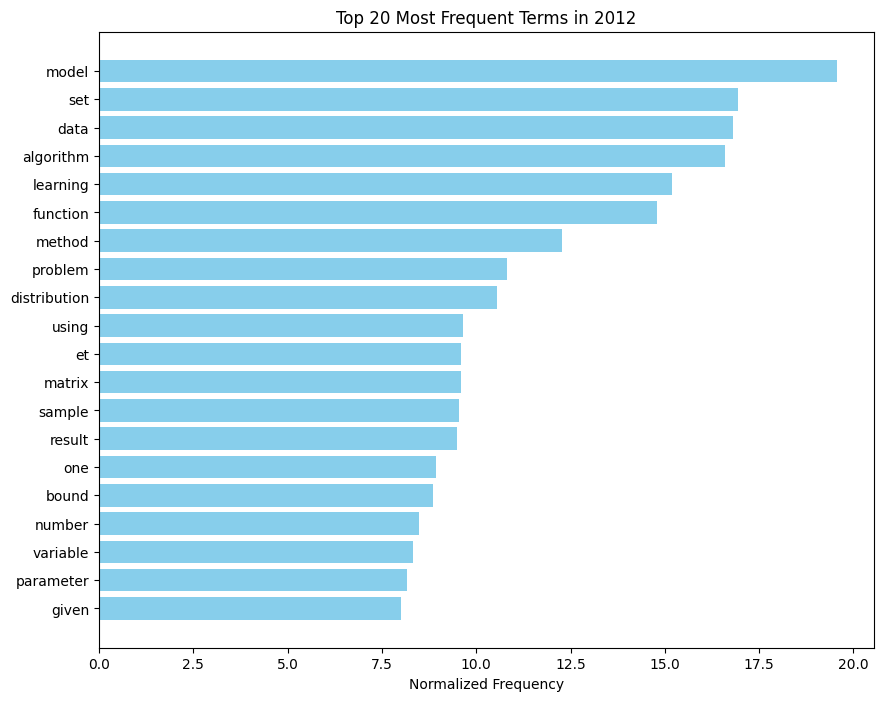

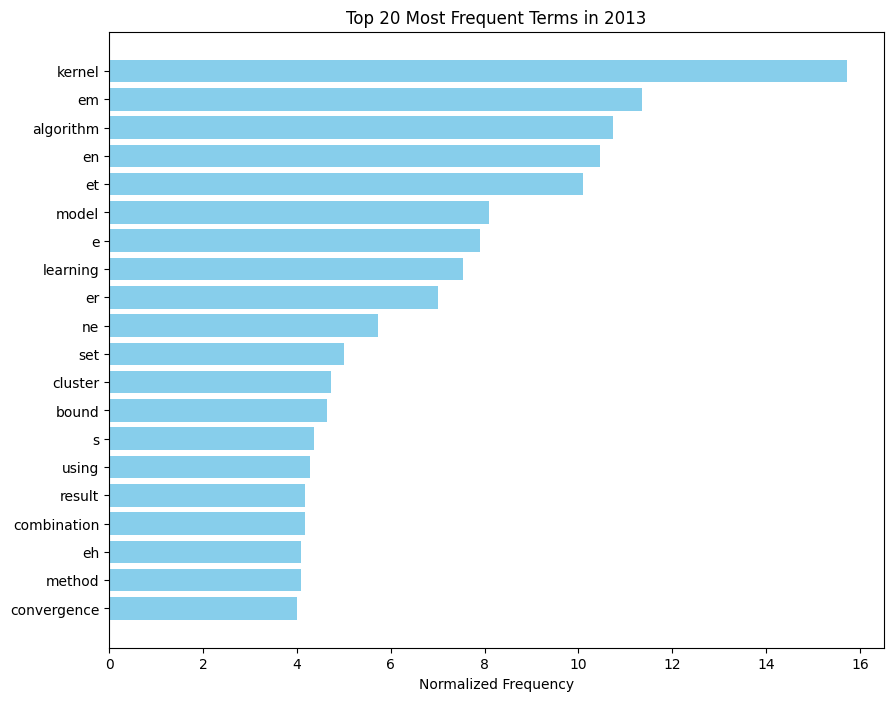

In [72]:
print(normalized_frequencies_by_year.keys())
top_terms_by_year = get_top_terms_per_year(normalized_frequencies_by_year)
plot_top_terms(top_terms_by_year)

A
2007
2008
2009
2010
2011
2012
2013
B
2007
2008
2009
2010
2011
2012
2013


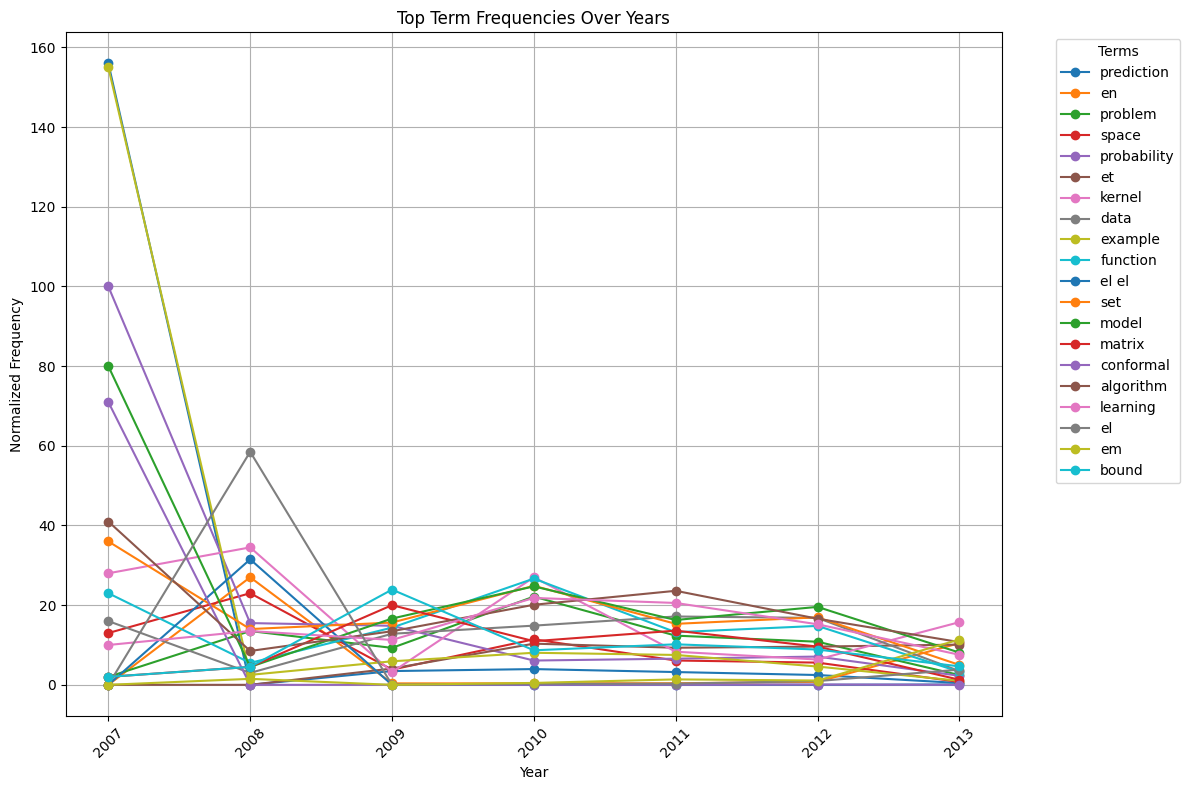

In [75]:
def identify_top_terms_over_years(normalized_frequencies_by_year, top_n=5):
    top_terms = set()
    top_terms_by_year = {}
    
    for year, frequencies in normalized_frequencies_by_year.items():
        sorted_terms = sorted(frequencies.items(), key=lambda x: x[1], reverse=True)[:top_n]
        top_terms_by_year[year] = sorted_terms
        top_terms.update([term for term, freq in sorted_terms])

    return top_terms, top_terms_by_year

top_terms, top_terms_by_year = identify_top_terms_over_years(normalized_frequencies_by_year)

def track_term_frequencies_over_years(top_terms, normalized_frequencies_by_year):
    terms_over_years = {term: [] for term in top_terms}
    years = sorted(normalized_frequencies_by_year.keys())
    
    for year in years:
        year_data = normalized_frequencies_by_year.get(year, {})
        for term in top_terms:
            terms_over_years[term].append(year_data.get(term, 0))

    return years, terms_over_years

years, terms_over_years = track_term_frequencies_over_years(top_terms, normalized_frequencies_by_year)

def plot_term_frequencies_over_years(years, terms_over_years):
    plt.figure(figsize=(12, 8))
    for term, frequencies in terms_over_years.items():
        plt.plot(years, frequencies, marker='o', label=term)

    plt.title('Top Term Frequencies Over Years')
    plt.xlabel('Year')
    plt.ylabel('Normalized Frequency')
    plt.legend(title="Terms", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.xticks(years, rotation=45)
    plt.tight_layout()
    plt.show()

plot_term_frequencies_over_years(years, terms_over_years)

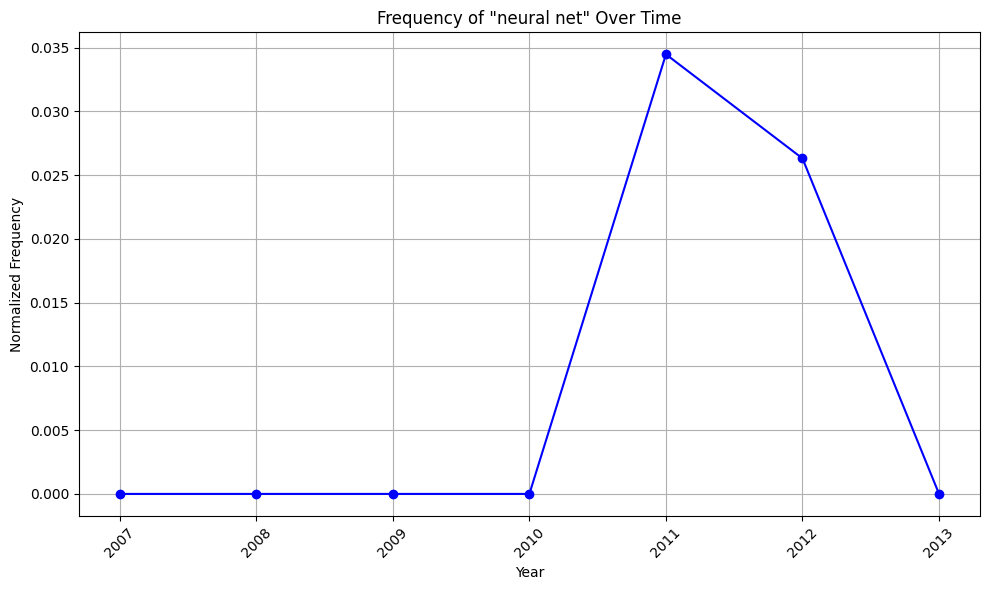

In [78]:
specific_term = "neural net"

term_frequency_over_years = {}
for year, frequencies in normalized_frequencies_by_year.items():
    term_frequency_over_years[year] = frequencies.get(specific_term, 0)

def plot_specific_term_over_time(term_frequency_over_years):
    # Sort years and get corresponding frequencies
    years = sorted(term_frequency_over_years.keys())
    frequencies = [term_frequency_over_years[year] for year in years]

    plt.figure(figsize=(10, 6))
    plt.plot(years, frequencies, marker='o', linestyle='-', color='b')
    plt.title(f'Frequency of "{specific_term}" Over Time')
    plt.xlabel('Year')
    plt.ylabel('Normalized Frequency')
    plt.grid(True)
    plt.xticks(years, rotation=45)
    plt.tight_layout()
    plt.show()

plot_specific_term_over_time(term_frequency_over_years)